# In-silico mixed Mouse Colon scRNA-seq data

This example uses TACCO to annotate and analyse in-silico mixtures of mouse colon scRNA-seq data (Avraham-Davidi et al.).

(Avraham-Davidi et al.): Avraham-Davidi I, Mages S, Klughammer J, et al. Integrative single cell and spatial transcriptomics of colorectal cancer reveals multicellular functional units that support tumor progression. doi: https://doi.org/10.1101/2022.10.02.508492

In [1]:
import os
import sys
import matplotlib

import pandas as pd
import numpy as np
import anndata as ad

import tacco as tc

# The notebook expects to be executed either in the workflow directory or in the repository root folder...
sys.path.insert(1, os.path.abspath('workflow' if os.path.exists('workflow/common_code.py') else '..')) 
import common_code

## Load data

In [2]:
reference_data_path = common_code.find_path('results/slideseq_mouse_colon/data')
plot_path = common_code.find_path('results/insilico_mouse_colon', create_if_not_existent=True)
env_path = common_code.find_path('results/env_links')
reference = ad.read(f'{reference_data_path}/scrnaseq.h5ad')

## Mix data in-silico

Generate in-silico mixtures of scRNA-seq data to benchmark methods with a known ground truth

In [3]:
bead_sizes = [0.5,1.0,1.5,2.0]

capture_rate = 1.0
bead_shape = 'gauss'
ntdata_max = 10**4

ref_annotation_key = 'labels'
tdata_annotation_key = 'reads_' + ref_annotation_key

sdatas = {}
for bead_size in bead_sizes:
    sdata = tc.tl.mix_in_silico(reference, type_key=ref_annotation_key, n_samples=ntdata_max, bead_shape=bead_shape, bead_size=bead_size, capture_rate=capture_rate,)
    sdata.obsm[tdata_annotation_key] /= sdata.obsm[tdata_annotation_key].to_numpy().sum(axis=1)[:,None]
    sdatas[bead_size] = sdata

## Plotting options

In [4]:
highres = False
default_dpi = 100.0
if highres:
    matplotlib.rcParams['figure.dpi'] = 648.0
    hr_ext = '_hd'
else:
    matplotlib.rcParams['figure.dpi'] = default_dpi
    hr_ext = ''

axsize = np.array([4,3])*0.5

labels_colors = pd.Series({'Epi': (0.00784313725490196, 0.24313725490196078, 1.0), 'B': (0.10196078431372549, 0.788235294117647, 0.2196078431372549), 'TNK': (1.0, 0.48627450980392156, 0.0), 'Mono': (0.5490196078431373, 0.03137254901960784, 0.0), 'Mac': (0.9098039215686274, 0.0, 0.043137254901960784), 'Gran': (0.34901960784313724, 0.11764705882352941, 0.44313725490196076), 'Mast': (0.23529411764705882, 0.23529411764705882, 0.23529411764705882), 'Endo': (0.8549019607843137, 0.5450980392156862, 0.7647058823529411), 'Fibro': (0.6235294117647059, 0.2823529411764706, 0.0)})

## Visualize scRNA-seq data

Create UMAP for the scRNA-seq data

SCumap...SCprep...time 10.525800943374634
time 80.12539029121399


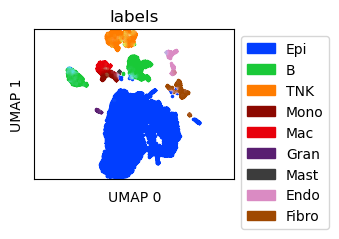

In [5]:
ref_umap = tc.utils.umap_single_cell_data(reference)
fig = tc.pl.scatter(ref_umap, keys='labels', position_key='X_umap', colors=labels_colors, joint=True, point_size=5, axsize=axsize, noticks=True,
axes_labels=['UMAP 0','UMAP 1']);

## Visualize in-silico mixtures

Create UMAP for the in-silico mixtures

SCumap...SCprep...time 6.028910398483276
time 46.6459801197052


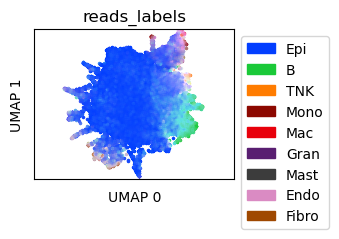

In [6]:
tdata = sdatas[1.0]
tdata_umap = tc.utils.umap_single_cell_data(tdata)
fig = tc.pl.scatter(tdata_umap, keys=tdata_annotation_key, position_key='X_umap', colors=labels_colors, joint=True, point_size=5, axsize=axsize, noticks=True,
axes_labels=['UMAP 0','UMAP 1']);

## Benchmark annotation methods on the in-silico mixtures with known ground truth

Define parameters for the annotation methods to use

In [7]:
methods = {
    'NMFreg':{'method': 'NMFreg',},
    'RCTD':{'method': 'RCTD', 'conda_env': f'{env_path}/RCTD_env',},
    'SVM':{'method':'svm',},
    'SingleR':{'method':'SingleR', 'conda_env': f'{env_path}/SingleR_env',},
    'WOT':{'method': 'WOT',},
    'TACCO': {'method': 'OT', 'multi_center': 10,},
}

In [8]:
results = {}
for bead_size in bead_sizes:
    for method,params in methods.items():
        print(f'running method {method} for bead size {bead_size} ...', end='')
        results[(bead_size,method)] = tc.benchmarking.benchmark_annotate(sdatas[bead_size],reference,annotation_key='labels',**params);
        print(f'done')

running method NMFreg for bead size 0.5 ...done
running method RCTD for bead size 0.5 ...done
running method SVM for bead size 0.5 ...done
running method SingleR for bead size 0.5 ...done
running method WOT for bead size 0.5 ...done
running method TACCO for bead size 0.5 ...done
running method NMFreg for bead size 1.0 ...done
running method RCTD for bead size 1.0 ...done
running method SVM for bead size 1.0 ...done
running method SingleR for bead size 1.0 ...done
running method WOT for bead size 1.0 ...done
running method TACCO for bead size 1.0 ...done
running method NMFreg for bead size 1.5 ...done
running method RCTD for bead size 1.5 ...done
running method SVM for bead size 1.5 ...done
running method SingleR for bead size 1.5 ...done
running method WOT for bead size 1.5 ...done
running method TACCO for bead size 1.5 ...done
running method NMFreg for bead size 2.0 ...done
running method RCTD for bead size 2.0 ...done
running method SVM for bead size 2.0 ...done
running method Single

In [9]:
for (bead_size,method),result in results.items():
    unused_key = tc.utils.find_unused_key(sdatas[bead_size].obsm)
    sdatas[bead_size].obsm[unused_key] = results[(bead_size,method)]['annotation']
    L2 = tc.ev.compute_err(sdatas[bead_size], unused_key, tdata_annotation_key, err_method='lp', p=2)[unused_key]
    del sdatas[bead_size].obsm[unused_key]
    results[(bead_size,method)]['L2'] = L2

In [10]:
res_df = pd.DataFrame([
    [bead_size,method,v['L2'],v['max_mem_usage_GB'],v['benchmark_time_s']]
    for (bead_size,method),v in results.items()
],columns=['beadsize','method','L2 error','memory (GB)','time (s)'])
quantities = [c for c in res_df.columns if c not in ['beadsize','method'] ]
methods = res_df['method'].unique()

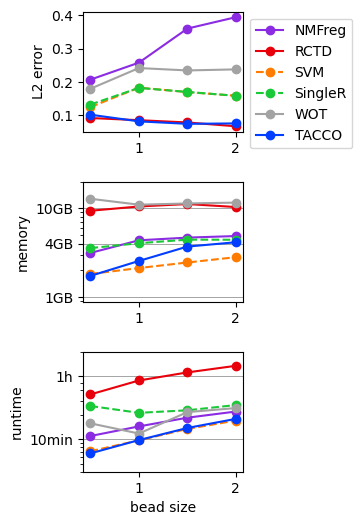

In [11]:
fig,axs = tc.pl.subplots(1,len(quantities), axsize=np.array([4,3])*0.4, x_padding=0.7, y_padding=0.5)
colors = {m:common_code.method_color(m) for m in methods}
styles = {m:common_code.method_style(m) for m in methods}
res_df = res_df.loc[~res_df[quantities].isna().all(axis=1)]
for iy_ax, qty in enumerate(quantities):
    ax = axs[iy_ax,0]

    x = res_df['beadsize']
    y = res_df[qty]

    if qty == 'time (s)': # part 1 of adding second, minute and hour marker: plot the lines under the data

        ynew = np.array([0.1,1,10,60,600,3600,36000])
        ynew_minor = np.concatenate([np.arange(0.1,1,0.1),np.arange(1,10,1),np.arange(10,60,10),np.arange(60,600,60),np.arange(600,3600,600),np.arange(3600,36000,3600)]).flatten()
        ynewlabels = np.array(['0.1s','1s','10s','1min','10min','1h','10h'])
        ymin = y.min() * 0.5
        ymax = y.max() * 2.0
        ynewlabels = ynewlabels[(ynew > ymin) & (ynew < ymax)]
        ynew = ynew[(ynew > ymin) & (ynew < ymax)]
        ynew_minor = ynew_minor[(ynew_minor > ymin) & (ynew_minor < ymax)]
        for yn in ynew:
            ax.axhline(yn, color='gray', linewidth=0.5)

    elif qty == 'memory (GB)':

        ynew = np.array([0.1,0.4,1,4,10,40,100])
        ynew_minor = np.concatenate([np.arange(0.1,1,0.1),np.arange(1,10,1),np.arange(10,100,10),np.arange(100,1000,100)]).flatten()
        ynewlabels = np.array(['0.1GB','0.4GB','1GB','4GB','10GB','40GB','100GB'])
        ymin = y.min() * 0.5
        ymax = y.max() * 2.0
        ynewlabels = ynewlabels[(ynew > ymin) & (ynew < ymax)]
        ynew = ynew[(ynew > ymin) & (ynew < ymax)]
        ynew_minor = ynew_minor[(ynew_minor > ymin) & (ynew_minor < ymax)]
        for yn in ynew:
            ax.axhline(yn, color='gray', linewidth=0.5)

    for m in methods:
        selector = res_df['method'] == m
        if selector.sum() == 0:
            continue
        ax.plot(x[selector],y[selector],label=m,marker='o',color=colors[m],ls=styles[m],)
    if iy_ax == axs.shape[0] - 1:
        ax.set_xlabel('bead size')
    if qty == 'time (s)':
        ax.set_ylabel('runtime')
    elif qty == 'memory (GB)':
        ax.set_ylabel('memory')
    else:
        ax.set_ylabel(f'{qty}')
    if qty in ['time (s)','memory (GB)']:
        ax.set_yscale('log')

    if qty in ['time (s)','memory (GB)']: # part 2 off adding second, minute and hour marker: add the second y axis after rescaling the first y axis to log scale
        ax.set_yticks(ynew_minor,minor=True)
        ax.set_yticks(ynew)
        ax.set_yticklabels(ynewlabels)
        ax.set_yticklabels([],minor=True)

    if iy_ax == 0:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

## Observation splitting

### Annotate the spatial data with compositions of cell types

Annotation is done on cell type level with multi_center=10 to capture variation within a cell type and with reconstruction_key set to save the annotation on the level of subclustered cell types for distributing all counts to pure cell type observations later.

In [12]:
tc.tl.annotate(tdata, reference, 'labels', result_key='TACCO', multi_center=10, reconstruction_key='rec')

Starting preprocessing
Annotation profiles were not found in `reference.varm["labels"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 11.76 seconds.
Starting annotation of data with shape (9971, 19661) and a reference of shape (17512, 19661) using the following wrapped method:
+- platform normalization: platform_iterations=0, gene_keys=labels, normalize_to=adata
   +- multi center: multi_center=10 multi_center_amplitudes=True
      +- bisection boost: bisections=4, bisection_divisor=3
         +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  0.7484176896456394 0.24026163784656937
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 68.32 seconds.


AnnData object with n_obs × n_vars = 9971 × 31053
    obs: 'x', 'y'
    var: 'gene_ids'
    uns: 'rec'
    obsm: 'labels', 'reads_labels', 'rec', 'TACCO'
    varm: 'rec'

### Split the mixed observations into pure contributions

Here we use the annotation on the subcluster level, saved during annotation in the reconstruction_key.

In [13]:
sdata = tc.tl.split_observations(tdata, 'rec', map_obs_keys=True, result_key='labels')

removed 11392 of 31053 genes from count matrix due to zero counts in gene
removed 11392 of 31053 genes from profile definition due to zero appearance in the profiles
scale.....time 142.23044776916504
fuseall...time 89.69051170349121


### Visualize the split observations

Create UMAP for the in-silico mixtures after observation split

SCumap...SCprep...time 7.842227220535278
time 32.2546226978302


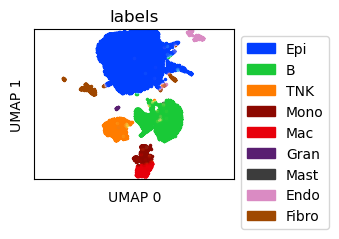

In [14]:
umap_sdata = tc.utils.umap_single_cell_data(sdata[tc.sum(sdata.X,axis=1)>=500])
fig = tc.pl.scatter(umap_sdata, 'labels', position_key='X_umap', colors=labels_colors, joint=True, point_size=5, axsize=axsize, noticks=True, axes_labels=['UMAP 0','UMAP 1']); 

Create UMAP for a joint embedding of reference and observation-split in-silico mixtures

SCprep...time 8.178986072540283
SCumap...SCprep...time 20.207684755325317
time 75.30178141593933


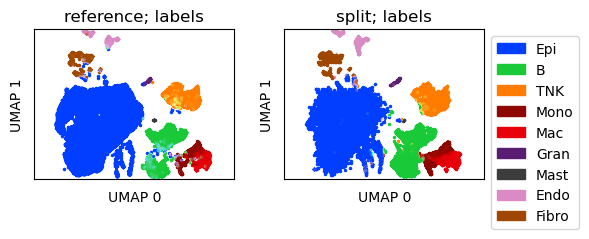

In [15]:
prep_ref = tc.utils.preprocess_single_cell_data(reference, hvg=True)
sdata.obs['HVGcounts'] = tc.sum(sdata[:,sdata.var.index.intersection(prep_ref.var.index)].X,axis=1)
sdata = sdata[sdata.obs['HVGcounts']>=50].copy()
scat = reference.concatenate([sdata],index_unique=None)
umap_scat = tc.utils.umap_single_cell_data(scat)
reference.obsm['X_umap'] = pd.DataFrame(umap_scat.obsm['X_umap'],index=umap_scat.obs.index).reindex(reference.obs.index)
sdata.obsm['X_umap'] = pd.DataFrame(umap_scat.obsm['X_umap'],index=umap_scat.obs.index).reindex(sdata.obs.index)

fig = tc.pl.scatter({'reference':reference,'split':sdata}, 'labels', position_key='X_umap', colors=labels_colors, joint=True, point_size=5, axsize=axsize, noticks=True, axes_labels=['UMAP 0','UMAP 1']); 